In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3237, done.
remote: Total 3237 (delta 0), reused 0 (delta 0), pack-reused 3237
Receiving objects: 100% (3237/3237), 582.59 MiB | 14.09 MiB/s, done.
Resolving deltas: 100% (1289/1289), done.
Checking out files: 100% (987/987), done.


In [ ]:
!mkdir -p /content/dataset/covid/
!mkdir -p /content/dataset/normal/
!mkdir -p /content/dataset/pneumonia/

In [ ]:
!unzip "/content/drive/My Drive/Datasets/Chest X-Ray Images (Pneumonia).zip"

In [ ]:
!mv /content/chest_xray/train/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/train/PNEUMONIA/* /content/dataset/pneumonia/
!mv /content/chest_xray/val/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/val/PNEUMONIA/* /content/dataset/pneumonia/
!mv /content/chest_xray/test/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/test/PNEUMONIA/* /content/dataset/pneumonia/

In [ ]:
import pandas as pd
import shutil
import os

# Selecting all combination of 'COVID-19' patients with 'PA' X-Ray view
virus = "COVID-19" # Virus to look for
x_ray_view = "PA" # View of X-Ray

meta_data = "/content/covid-chestxray-dataset/metadata.csv"
images_dir = "/content/covid-chestxray-dataset/images"
output_dir = "/content/dataset/covid/"

metadata_csv = pd.read_csv(meta_data)

for (i, row) in metadata_csv.iterrows():
	if row["finding"] != virus or row["view"] != x_ray_view:
		continue

	filename = row["filename"].split(os.path.sep)[-1]
	filePath = os.path.sep.join([images_dir, filename])
	shutil.copy2(filePath, output_dir)

In [ ]:
# !git clone https://github.com/UCSD-AI4H/COVID-CT.git

In [ ]:
# !unzip /content/COVID-CT/Images-processed/CT_COVID.zip
# !unzip /content/COVID-CT/Images-processed/CT_NonCOVID.zip

In [ ]:
# !mv /content/CT_COVID/* /content/dataset/covid/

In [ ]:
# !unzip "/content/drive/My Drive/Datasets/COVID19/COV-Img.zip"

In [ ]:
# !mkdir -p /content/test/covid/

In [ ]:
# !mv /content/COV-Img/* /content/test/covid/

  ## Dependencies 

In [ ]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Input, average, Average, concatenate
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense

from keras.models import Sequential, Model
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications import ResNet101
from keras.applications import DenseNet201
from keras.applications import MobileNet
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

import os
import numpy as np
import pandas as pd
import time

import random

from PIL import Image
import glob
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


In [ ]:
DATASET_DIR = "/content/dataset"

NORMAL_DIR = DATASET_DIR + "/normal"
PNEUMONIA_DIR = DATASET_DIR + "/pneumonia"
COVID_DIR = DATASET_DIR + "/covid"

NORMAL_TRAIN_SAMPLES = 1200 # total samples = 1583
PNEUMONIA_TRAIN_SAMPLES = 2000 # total samples = 4273
COVID_TRAIN_SAMPLES = 160 # total samples = 201

IMG_W = 224
IMG_H = 224
IMG_C = 1
INPUT_SHAPE = (IMG_W, IMG_H, IMG_C)

CLASSES = [ "NORMAL", "PNEUMONIA", "COVID" ]
NB_CLASSES = len(CLASSES)

EPOCHS = 5
BATCH_SIZE = 16

In [ ]:
normal_images = []
pneumonia_images = []
covid_images = []

In [ ]:
for img_path in glob.glob(NORMAL_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    # img = img / 255.
    normal_images.append(img[:np.newaxis])

for img_path in glob.glob(PNEUMONIA_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    # img = img / 255.
    pneumonia_images.append(img[:np.newaxis])

for img_path in glob.glob(COVID_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    # img = img / 255.
    covid_images.append(img[:np.newaxis])

In [ ]:
len(normal_images), len(pneumonia_images), len(covid_images)

(1583, 4273, 204)

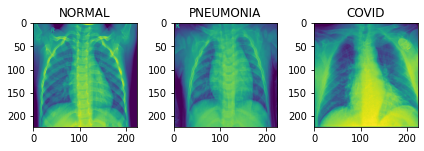

In [ ]:
width=150
height=150
rows = 1
cols = 3

imgs = [ normal_images[0], pneumonia_images[0], covid_images[0]]

axes=[]
fig=plt.figure()

for i in range(rows*cols):
    img = imgs[i]
    axes.append( fig.add_subplot(rows, cols, i+1) )
    plt.imshow(img)

axes[0].set_title('NORMAL')
axes[1].set_title('PNEUMONIA')
axes[2].set_title('COVID')
fig.tight_layout()    
plt.show()

In [ ]:
normal_X = []
pneumonia_X = []
covid_X = []
normal_y = []
pneumonia_y = []
covid_y = []
X = []
y = []

for item in normal_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    normal_X.append(img)    
    normal_y.append(CLASSES.index("NORMAL"))   
    X.append(img)    
    y.append(CLASSES.index("NORMAL"))

for item in pneumonia_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    pneumonia_X.append(img)    
    pneumonia_y.append(CLASSES.index("PNEUMONIA"))   
    X.append(img)    
    y.append(CLASSES.index("PNEUMONIA"))

for item in covid_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    covid_X.append(img) 
    covid_y.append(CLASSES.index("COVID"))   
    X.append(img)    
    y.append(CLASSES.index("COVID"))

X = np.asarray(X)
y = np.asarray(y)

In [ ]:
X.shape, y.shape

((6060, 224, 224, 1), (6060,))

In [ ]:
X_train_normal = normal_X[:NORMAL_TRAIN_SAMPLES]
X_train_pneumonia = pneumonia_X[:PNEUMONIA_TRAIN_SAMPLES]
X_train_covid = covid_X[:COVID_TRAIN_SAMPLES]
X_test_normal = normal_X[NORMAL_TRAIN_SAMPLES:]
X_test_pneumonia = pneumonia_X[PNEUMONIA_TRAIN_SAMPLES:]
X_test_covid = covid_X[COVID_TRAIN_SAMPLES:]

y_train_normal = normal_y[:NORMAL_TRAIN_SAMPLES]
y_train_pneumonia = pneumonia_y[:PNEUMONIA_TRAIN_SAMPLES]
y_train_covid = covid_y[:COVID_TRAIN_SAMPLES]
y_test_normal = normal_y[NORMAL_TRAIN_SAMPLES:]
y_test_pneumonia = pneumonia_y[PNEUMONIA_TRAIN_SAMPLES:]
y_test_covid = covid_y[COVID_TRAIN_SAMPLES:]


X_train = np.concatenate((X_train_normal, X_train_pneumonia, X_train_covid), axis=0) 
y_train = np.concatenate((y_train_normal, y_train_pneumonia, y_train_covid), axis=0) 

X_test = np.concatenate((X_test_normal, X_test_pneumonia, X_test_covid), axis=0) 
y_test = np.concatenate((y_test_normal, y_test_pneumonia, y_test_covid), axis=0) 

In [ ]:
# np.full((len(X_train_normal), 1), y_test_normal[0]).shape

In [ ]:
X_train.shape, y_train.shape

((3360, 224, 224, 1), (3360,))

In [ ]:
X_test.shape, y_test.shape

((2700, 224, 224, 1), (2700,))

In [ ]:
a = list(zip(X_train, y_train))
random.shuffle(a)
X_train, y_train = zip(*a)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
# a = list(zip(X_train, y_train))
# random.shuffle(a)
# X_test, y_test = zip(*a)

In [ ]:
X_train.shape, y_train.shape

((3360, 224, 224, 1), (3360,))

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=2020)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
# ----------------------

In [ ]:
X_train = np.repeat(X_train[...,], 3, 3)
X_val = np.repeat(X_val[...,], 3, 3)
X_test = np.repeat(X_test[...,], 3, 3)

In [ ]:
X_train.shape, y_train.shape

((2520, 224, 224, 3), (2520,))

In [ ]:
X_val.shape, y_val.shape

((840, 224, 224, 3), (840,))

In [ ]:
X_test.shape, y_test.shape

((2700, 224, 224, 3), (2700,))

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([ 913, 1485,  122]))

In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([ 383, 2273,   44]))

In [ ]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
train_da_args = dict(rescale=1./255, 
               shear_range=0.2,
               zoom_range=0.05,
               width_shift_range=0.05,
               height_shift_range=0.05,
               rotation_range=360,
               #  brightness_range=[0.2,1.0],
               vertical_flip=True,
               horizontal_flip=True)

# val_da_args = dict(rescale=1./255)

train_da = ImageDataGenerator(train_da_args)
# val_da = ImageDataGenerator(val_da_args)

train_da.fit(X_train, augment=True)
# val_da.fit(X_train)

train_gen = train_da.flow(X_train, y_train, batch_size=BATCH_SIZE)
# val_gen = train_da.flow(X_val, y_val)

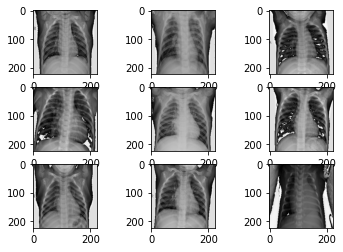

In [ ]:
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	batch = train_gen.next()
	image = batch[0][0].astype('uint8')
	pyplot.imshow(image)

pyplot.show()

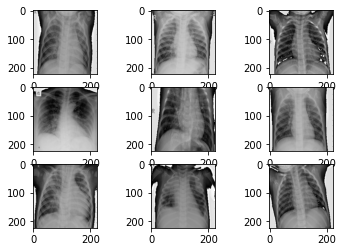

In [ ]:
for i in range(9):
	
	pyplot.subplot(330 + 1 + i)
	batch = train_gen.next()
	image = batch[0][-1].astype('uint8')
	pyplot.imshow(image)

pyplot.show()

In [ ]:
# augmented_data = []
# num_augmented = 0
# for X_batch, y_batch in train_da.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=False):
#     augmented_data.append(X_batch)
#     num_augmented += BATCH_SIZE
#     if num_augmented == X_train.shape[0]:
#         break
# augmented_data = np.concatenate(augmented_data)

In [ ]:
# -------------------------

In [ ]:
# len(train_gen.x) 

In [ ]:
# vgg_model = VGG16(weights='imagenet', 
#                         include_top=False, 
#                         input_shape=(IMG_H, IMG_W, 3))

# for layer in vgg_model.layers:
#     if isinstance(layer, BatchNormalization):
#         layer.trainable = True
#     else:
#         layer.trainable = False

# model = Sequential()
# model.add(vgg_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(NB_CLASSES, activation='softmax'))

In [ ]:
models_input = Input(shape=(IMG_H, IMG_W, 3))


xception_model = Xception(weights='imagenet', 
                        include_top=False, 
                        input_tensor=models_input)

for layer in xception_model.layers:
    layer.name = "xception_" + layer.name
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
        
        
xception_gap = GlobalAveragePooling2D()(xception_model.output)

# x = Dense(256)(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# x = Activation('relu')(x)
# x = BatchNormalization()(x)
# x = Dense(NB_CLASSES)(x)
# out = Activation('softmax')(x)
# resnet_model = Model(inputs=resnet_model.input, outputs=out)


# vgg_model = VGG16(weights='imagenet', 
#                         include_top=False, 
#                         input_tensor=models_input)

# for layer in vgg_model.layers:
#     layer.name = "vgg16_" + layer.name
#     if isinstance(layer, BatchNormalization):
#         layer.trainable = True
#     else:
#         layer.trainable = False

        
# vgg_gap = GlobalAveragePooling2D()(vgg_model.output)

# # x = GlobalAveragePooling2D()(vgg_model.output)
# x = Dense(256)(vgg_gap)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# x = Activation('relu')(x)
# vgg_out = BatchNormalization()(x)
# x = Dense(NB_CLASSES)(x)
# out = Activation('softmax')(x)

# merged_nets = concatenate([resnet_gap, vgg_gap])

x = Dense(NB_CLASSES)(xception_gap)
out = Activation('softmax')(x)

inputs = input_tensor=models_input
outputs = out # out # average([resnet_model.output, vgg_model.output])
model = Model(inputs, outputs)

In [ ]:
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
xception_input_2 (InputLayer)   (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
xception_block1_conv1 (Conv2D)  (None, 111, 111, 32) 864         xception_input_2[0][0]           
__________________________________________________________________________________________________
xception_block1_conv1_bn (Batch (None, 111, 111, 32) 128         xception_block1_conv1[0][0]      
__________________________________________________________________________________________________
xception_block1_conv1_act (Acti (None, 111, 111, 32) 0           xception_block1_conv1_bn[0][0]   
____________________________________________________________________________________________

In [ ]:
len(train_gen.x) // BATCH_SIZE

157

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# # model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
# #           steps_per_epoch=  x_train.shape[0]//batch_size,
# #           epochs=epochs,
# #           verbose=1,
# #           class_weight=class_weight_dic)

# hist = model.fit_generator(train_gen,
#                     steps_per_epoch=len(train_gen.x)//BATCH_SIZE,
#                     epochs=EPOCHS,
#                     validation_data=(X_val, y_val),
#                     validation_steps=X_val.shape[0]//BATCH_SIZE)

In [ ]:
hist = model.fit(X_train, 
                 y_train, 
                 batch_size=BATCH_SIZE, 
                 epochs=EPOCHS, 
                 verbose=1, 
                 callbacks=None, 
                 validation_data=(X_val, y_val))

Train on 2520 samples, validate on 840 samples
Epoch 1/5
2520/2520 [==============================] - 65s 26ms/step - loss: 0.4127 - accuracy: 0.8425 - val_loss: 0.3319 - val_accuracy: 0.8881
Epoch 2/5
2520/2520 [==============================] - 57s 23ms/step - loss: 0.2135 - accuracy: 0.9242 - val_loss: 0.1562 - val_accuracy: 0.9417
Epoch 3/5
2520/2520 [==============================] - 58s 23ms/step - loss: 0.1623 - accuracy: 0.9425 - val_loss: 0.1204 - val_accuracy: 0.9583
Epoch 4/5
2520/2520 [==============================] - 58s 23ms/step - loss: 0.0973 - accuracy: 0.9615 - val_loss: 0.1237 - val_accuracy: 0.9548
Epoch 5/5
2520/2520 [==============================] - 57s 23ms/step - loss: 0.0760 - accuracy: 0.9746 - val_loss: 0.1122 - val_accuracy: 0.9583


In [ ]:
model.evaluate(X_test, y_test)

2700/2700 [==============================] - 18s 7ms/step


[0.11235766528381241, 0.9562963247299194]

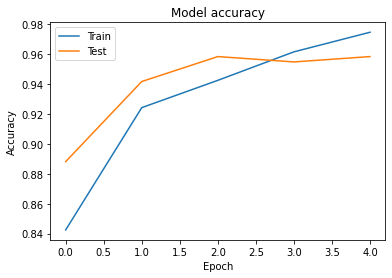

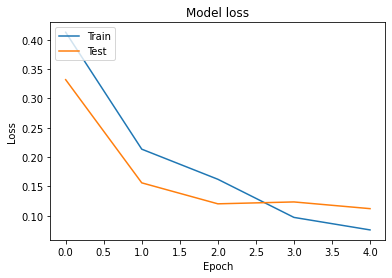

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Confusion matrix
# Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)

    thresh = np.max(cm) // 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

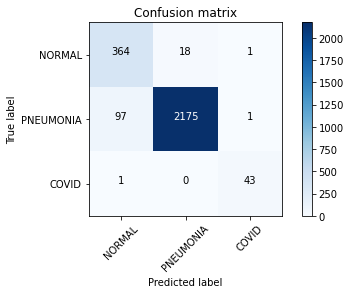

In [ ]:
plot_confusion_matrix(confusion_mtx, classes = CLASSES)

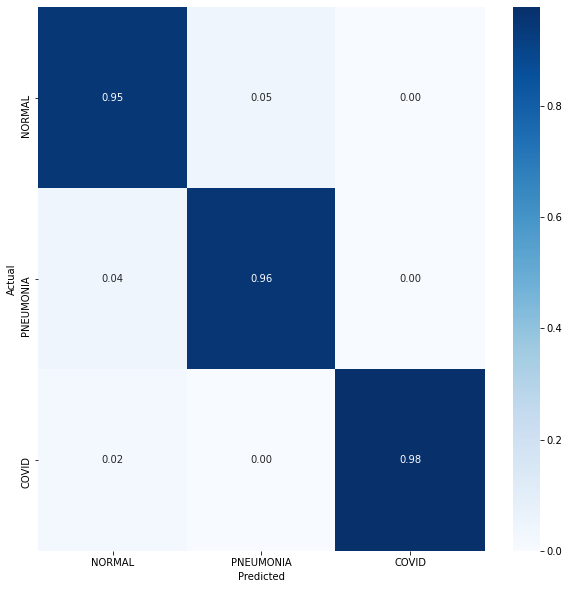

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# plot_confusion_matrix(confusion_mtx, classes = CLASSES, normalize=True)
conf_mat = confusion_matrix(Y_true, Y_pred_classes)
# Normalise
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat_norm, annot=True, cmap=plt.cm.Blues, fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       383
           1       0.99      0.96      0.97      2273
           2       0.96      0.98      0.97        44

    accuracy                           0.96      2700
   macro avg       0.91      0.96      0.93      2700
weighted avg       0.96      0.96      0.96      2700



In [ ]:
model.save_weights('Covid19_Detection_pretrained_ResNet_VGG_3_Epochs.h5')

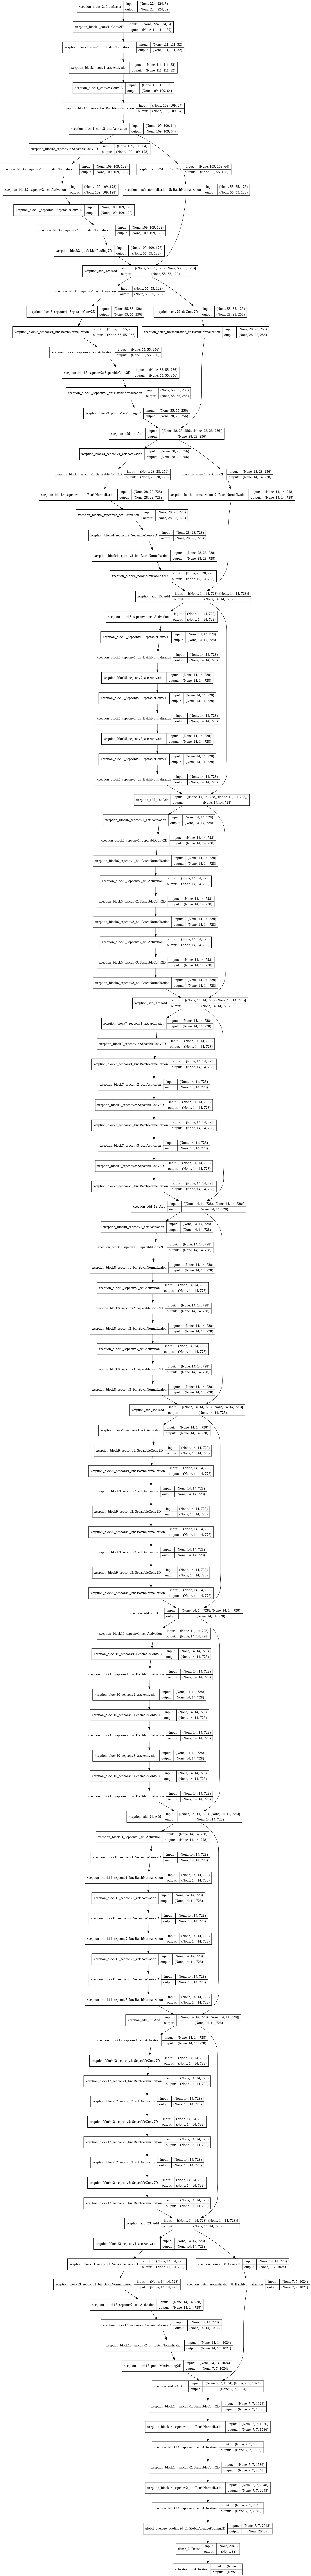

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='Covid19_Detection_pretrained_ResNet_VGG_3_Epochs.png')